In [13]:
# necessary imports
# !pip install pm4py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pm4py


np.random.seed(123)

## Import data

Specify the names of bpmn diagram (should be stored in bpmn_diagrams), log file (as a csv file, should be stored in logs_folder) and bpmn specifics (should be stored in bpmn_specifics folder as csv files)

Empty File Created Successfully


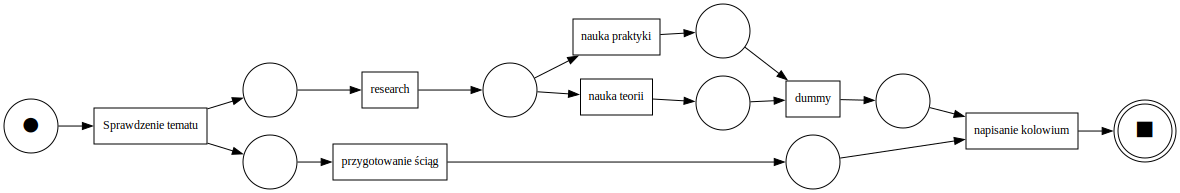

In [196]:
# EDIT BELOW #
##############
bpmn_diagram = 'kolokwium.bpmn'
bpmn_specifics = 'kolokwium.csv'
csv_to_save_results = 'kolokwium_results.csv'
############
# END EDIT #

path_to_bpmn_diagram = 'bpmn_diagrams/' + bpmn_diagram
path_to_specifics = 'bpmn_specifics/' + bpmn_specifics
csv_destination = csv_to_save_results

with open(csv_destination, 'w') as creating_new_csv_file: 
   pass 
print("Empty File Created Successfully")

# loading bpmn into python through pm4py
bpmn = pm4py.read_bpmn(path_to_bpmn_diagram)


# transfomring it into petri net
# sometimes loses the last task for some reason?
net, im, fm = pm4py.convert_to_petri_net(bpmn)
pm4py.visualization.petri_net.variants.alignments.apply(net, im, fm)

In [197]:
# simulating logs with pm4py
from pm4py.algo.simulation.playout.petri_net.variants import extensive
# log = pm4py.play_out(net, im, fm)
# log = pm4py.play_out(process_tree_test)
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
log = simulator.apply(net, im, variant=simulator.Variants.EXTENSIVE, parameters={simulator.Variants.EXTENSIVE.value.Parameters.MAX_TRACE_LENGTH: 20})
                                    
from pm4py.objects.conversion.log.variants import to_data_frame
log_df = to_data_frame.apply(log)

log_df.head(10)

,concept:name,time:timestamp,case:concept:name
0,Sprawdzenie tematu,1970-04-26 18:46:41+00:00,0
1,przygotowanie ściąg,1970-04-26 18:46:42+00:00,0
2,research,1970-04-26 18:46:43+00:00,0
3,nauka praktyki,1970-04-26 18:46:44+00:00,0
4,Sprawdzenie tematu,1970-04-26 18:46:45+00:00,1
5,przygotowanie ściąg,1970-04-26 18:46:46+00:00,1
6,research,1970-04-26 18:46:47+00:00,1
7,nauka teorii,1970-04-26 18:46:48+00:00,1
8,Sprawdzenie tematu,1970-04-26 18:46:49+00:00,2
9,research,1970-04-26 18:46:50+00:00,2


In [198]:
# having the logs we split the dataframe into individual dataframes according to case:concept:name
unique_ids = log_df['case:concept:name'].unique()
log_dfs_by_id = []
for id in unique_ids:
    log_df_id = log_df[log_df['case:concept:name'] == id]
    log_dfs_by_id.append(log_df_id)
    
# assuming equal probability of each found path from the graph --> customisation of this part to be added later
length = len(unique_ids)
unique_ids_times_of_occurence = np.random.normal(100, 3, length).round()


In [199]:
# most important element - generating data based off of specifics 
# first create a df to store data 
bpmn_specifics_df = pd.read_csv(path_to_specifics, na_values=[0, '-'])
bpmn_specifics_df.head()

,task_name,time_dist,time_unit,costs_dist,costs_unit,profit_dists,profit_unit
0,Sprawdzenie tematu,NaN,NaN,NaN,NaN,NaN,NaN
1,research,"linear(1,4)",hour,"linear(1,4)",morale,"linear(1,2)",knowledge
2,nauka praktyki,"linear(1,3)",hour,"linear(1,3)",mental_units,"linear(1,2)",street_smarts
3,przygotowanie ściąg,"linear(1,10)",hour,"linear(1,10)",mental_units,"linear(1,2)",knowledge
4,nauka teorii,"linear(1,2)",hour,"linear(1,2)",mental_units,"linear(1,2)",knowledge


In [200]:
specifics_copy = bpmn_specifics_df.dropna()
time_units = specifics_copy['time_unit'].unique()
costs_units = specifics_copy['costs_unit'].unique()
profit_units = specifics_copy['profit_unit'].unique()

profit_dict = dict.fromkeys(profit_units, 0)
time_dict = dict.fromkeys(time_units, 0)
costs_dict = dict.fromkeys(costs_units, 0)

for i, path_log in enumerate(log_dfs_by_id):
    num_of_occurence = unique_ids_times_of_occurence[i]
    for j in range(int(num_of_occurence)):
        for k, event in enumerate(path_log.values):
            task_name_ = event[0]
            task_specifics = bpmn_specifics_df[bpmn_specifics_df['task_name'] == task_name_]
            
            time_dist_string = task_specifics['time_dist'].values[0]
            time_unit = task_specifics['time_unit'].values[0]
            
            cost_dist_string = task_specifics['costs_dist'].values[0]
            cost_unit = task_specifics['costs_unit'].values[0]
            
            profit_dist_string = task_specifics['profit_dists'].values[0]
            profit_unit = task_specifics['profit_unit'].values[0]
            
            # calculating time
            if time_dist_string is not np.nan:
                name, data = time_dist_string.split('(')
                data = data.replace(')', '')
                data = np.array(data.split(',')).astype(int)
                
                if name == 'linear':
                    value_generated = np.random.uniform(data[0], data[1])
                    time_dict[time_unit] = time_dict[time_unit] + value_generated
                    
                elif name == 'normal':
                    value_generated = np.random.normal(data[0], data[1])
                    time_dict[time_unit] = time_dict[time_unit] + value_generated
                
                elif name == 'lognormal':
                    value_generated = np.random.lognormal(data[0], data[1])
                    time_dict[time_unit] = time_dict[time_unit] + value_generated
                    
                else:
                    raise ValueError('wrong input from specifics')
            
            # calculating costs:
            if cost_dist_string is not np.nan:
                name, data = cost_dist_string.split('(')
                data = data.replace(')', '')
                data = np.array(data.split(',')).astype(int)
                
                if name == 'linear':
                    value_generated = np.random.uniform(data[0], data[1])
                    costs_dict[cost_unit] = costs_dict[cost_unit] + value_generated
                    
                elif name == 'normal':
                    value_generated = np.random.normal(data[0], data[1])
                    costs_dict[cost_unit] = costs_dict[cost_unit] + value_generated
                
                elif name == 'lognormal':
                    value_generated = np.random.lognormal(data[0], data[1])
                    costs_dict[cost_unit] = costs_dict[cost_unit] + value_generated

                else:
                    raise ValueError('wrong input from specifics')
            
            #calculating profits
            if profit_dist_string is not np.nan:
                name, data = profit_dist_string.split('(')
                data = data.replace(')', '')
                data = np.array(data.split(',')).astype(int)
                
                if name == 'linear':
                    value_generated = np.random.uniform(data[0], data[1])
                    profit_dict[profit_unit] = profit_dict[profit_unit] + value_generated
                    
                elif name == 'normal':
                    value_generated = np.random.normal(data[0], data[1])
                    profit_dict[profit_unit] = profit_dict[profit_unit] + value_generated
                
                elif name == 'lognormal':
                    value_generated = np.random.lognormal(data[0], data[1])
                    profit_dict[profit_unit] = profit_dict[profit_unit] + value_generated

                else:
                    raise ValueError('wrong input from specifics')
                

In [201]:
profits_and_costs = profit_units.tolist() + costs_units.tolist()
balance = {}
for unit in profits_and_costs:
    if unit in profit_units and unit in costs_units:
        balance[unit] = profit_dict[unit] - costs_dict[unit]
    elif unit in profit_units:
        balance[unit] = profit_dict[unit]
    else:
        balance[unit] = -costs_dict[unit]

print(balance)

{'knowledge': 2278.476401920102, 'street_smarts': 444.22696204806385, 'morale': -1505.2992532786525, 'mental_units': -4340.09406199708}


In [203]:
print('Final calculated balance after simulation:')
print('\n')
for key, value in balance.items():
    print(key, ': ', value)

print('\n')
print('Saving to csv, destination: ', csv_destination)
pd.DataFrame(balance, index=[0]).to_csv(csv_destination, mode='w')
print('Saved')

Final calculated balance after simulation:


knowledge :  2278.476401920102
street_smarts :  444.22696204806385
morale :  -1505.2992532786525
mental_units :  -4340.09406199708


Saving to csv, destination:  kolokwium_results.csv
Saved
